```
Rental Listings Analysis
By Prashant Tatineni
```
# Project Overview
In this project, I attempt to predict the popularity (target variable: `interest_level`) of apartment rental listings in New York City based on listing characteristics. The data itself comes from a [Kaggle Competition](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries) hosted in conjunction with [renthop.com](https://www.renthop.com/).  
  
The dataset was provided as a single file `train.json` (49,352 rows).  
  
An additional file, `test.json` (74,659 rows) contains the same columns as `train.json`, except that the target variable, `interest_level`, is missing. Predictions of the target variable are to be made on the `test.json` file and submitted to Kaggle.

## Summary of Solution Steps
1. Load data from JSON
2. Build initial predictor variables, with `interest_level` as the target.
3. Initial run of classification models.
4. Add category indicators and aggregated features based on manager_id.
5. Run new Random Forest model.
6. An attempt to use the images for classification.
7. Further opportunities with this dataset.

In [1]:
# imports

import pandas as pd
import dateutil.parser
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline

## Step 1: Load Data

In [2]:
# Load the training dataset from Kaggle.
df = pd.read_json('train.json')
print df.shape

(49352, 15)


In [3]:
df.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue


**Total number of columns is 14 + 1 target:**
- 1 target variable (**interest_level**), with classes **low, medium, high**
- 1 list of photo links
- lat/long, street address, display address
- listing_id, building_id, manager_id
- numerical (price, bathrooms, bedrooms)
- created date
- text (description, features)

**Features for modeling:**  
- bathrooms
- bedrooms
- created date (calculate age of posting in days)
- description (number of words in description)
- features (number of features)
- photos (number of photos)
- price
- features (split into category indicators)
- manager_id (with manager skill level)

**Further opportunities for modeling:**
- description (with NLP)
- building_id (with a building popularity level)
- photos (quality, discussed in Step 6)

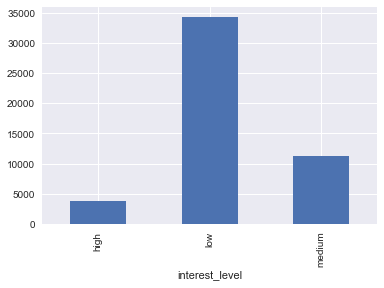

In [43]:
# Distribution of target value: interest_level

s = df.groupby('interest_level')['listing_id'].count()
s.plot.bar();

In [5]:
df_high = df.loc[df['interest_level'] == 'high']
df_medium = df.loc[df['interest_level'] == 'medium']
df_low = df.loc[df['interest_level'] == 'low']

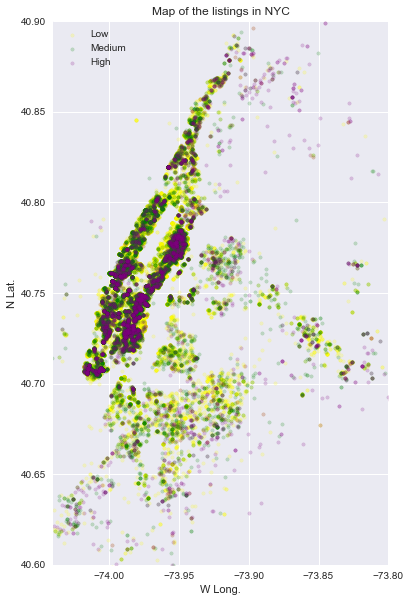

In [46]:
plt.figure(figsize=(6,10))
plt.scatter(df_low.longitude, df_low.latitude, color='yellow', alpha=0.2, marker='.', label='Low')
plt.scatter(df_medium.longitude, df_medium.latitude, color='green', alpha=0.2, marker='.',  label='Medium')
plt.scatter(df_high.longitude, df_high.latitude, color='purple', alpha=0.2, marker='.',  label='High')

plt.xlim(-74.04,-73.80)
plt.ylim(40.6,40.9)
plt.title('Map of the listings in NYC')
plt.ylabel('N Lat.')
plt.xlabel('W Long.')
plt.legend(loc=2);

## Step 2: Initial Features

In [7]:
(pd.to_datetime(df['created'])).sort_values(ascending=False).head()

28466   2016-06-29 21:41:47
34914   2016-06-29 18:30:41
622     2016-06-29 18:14:48
26349   2016-06-29 17:56:12
335     2016-06-29 17:47:34
Name: created, dtype: datetime64[ns]

In [8]:
# The most recent records are 6/29/2016. Computing days old from 6/30/2016.
df['days_old'] = (dateutil.parser.parse('2016-06-30') - pd.to_datetime(df['created'])).apply(lambda x: x.days)

In [9]:
# Add other "count" features
df['num_words'] = df['description'].apply(lambda x: len(x.split()))
df['num_features'] = df['features'].apply(len)
df['num_photos'] = df['photos'].apply(len)

## Step 3: Modeling, First Pass

In [10]:
X = df[['bathrooms','bedrooms','price','latitude','longitude','days_old','num_words','num_features','num_photos']]
y = df['interest_level']

In [11]:
# Scaling is necessary for Logistic Regression and KNN
X_scaled = pd.DataFrame(preprocessing.scale(X))
X_scaled.columns = X.columns

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)

### Logistic Regression

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
y_test_predicted_proba = lr.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.72358877058510196

In [15]:
lr = LogisticRegression(solver='newton-cg', multi_class='multinomial')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
y_test_predicted_proba = lr.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.71939997996865968

### KNN

In [17]:
for i in [95,100,105]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_test_predicted_proba = knn.predict_proba(X_test)
    print log_loss(y_test, y_test_predicted_proba)

0.765759270842
0.765584342679
0.765560629848


### Random Forest

In [33]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [34]:
y_test_predicted_proba = rf.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.62981513318807736

#### Random Forest performs the best with respect to Log Loss.

In [40]:
y_test_predicted = rf.predict(X_test)
accuracy_score(y_test, y_test_predicted)

0.72288863673204728

In [41]:
precision_recall_fscore_support(y_test, y_test_predicted)

(array([ 0.49083503,  0.7713531 ,  0.48831488]),
 array([ 0.25556734,  0.92851254,  0.27341598]),
 array([ 0.33612273,  0.84266781,  0.35055188]),
 array([ 943, 8491, 2904]))

In [37]:
rf.classes_

array([u'high', u'low', u'medium'], dtype=object)

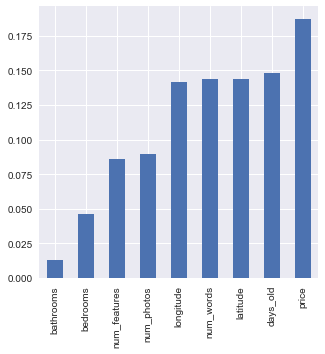

In [42]:
plt.figure(figsize=(5,5))
pd.Series(index = X_train.columns, data = rf.feature_importances_).sort_values().plot(kind= 'bar');

#### The above bar plot shows feature importance for the Random Forest classifier. "Price" is the most informative feature related to the target variable "interest_level".

### Naive Bayes

In [72]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [73]:
y_test_predicted_proba = bnb.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.76915047053579133

In [74]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None)

In [75]:
y_test_predicted_proba = gnb.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

4.445755558020128

### Neural Network

In [76]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,10))
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [77]:
y_test_predicted_proba = clf.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.65649310927267335

## Step 4: More Complex Features

### Splitting out categories into 0/1 dummy variables

In [62]:
# Reduce 1556 unique category text values into 34 main categories

def reduce_categories(full_list):
    reduced_list = []
    for i in full_list:
        item = i.lower()
        if 'cats allowed' in item:
            reduced_list.append('cats')
        if 'dogs allowed' in item:
            reduced_list.append('dogs')
        if 'elevator' in item:
            reduced_list.append('elevator')
        if 'hardwood' in item:
            reduced_list.append('elevator')
        if 'doorman' in item or 'concierge' in item:
            reduced_list.append('doorman')
        if 'dishwasher' in item:
            reduced_list.append('dishwasher')
        if 'laundry' in item or 'dryer' in item:
            if 'unit' in item:
                reduced_list.append('laundry_in_unit')
            else:
                reduced_list.append('laundry')
        if 'no fee' in item:
            reduced_list.append('no_fee')
        if 'reduced fee' in item:
            reduced_list.append('reduced_fee')
        if 'fitness' in item or 'gym' in item:
            reduced_list.append('gym')
        if 'prewar' in item or 'pre-war' in item:
            reduced_list.append('prewar')
        if 'dining room' in item:
            reduced_list.append('dining')
        if 'pool' in item:
            reduced_list.append('pool')
        if 'internet' in item:
            reduced_list.append('internet')
        if 'new construction' in item:
            reduced_list.append('new_construction')
        if 'wheelchair' in item:
            reduced_list.append('wheelchair')
        if 'exclusive' in item:
            reduced_list.append('exclusive')
        if 'loft' in item:
            reduced_list.append('loft')
        if 'simplex' in item:
            reduced_list.append('simplex')
        if 'fire' in item:
            reduced_list.append('fireplace')
        if 'lowrise' in item or 'low-rise' in item:
            reduced_list.append('lowrise')
        if 'midrise' in item or 'mid-rise' in item:
            reduced_list.append('midrise')
        if 'highrise' in item or 'high-rise' in item:
            reduced_list.append('highrise')
        if 'pool' in item:
            reduced_list.append('pool')
        if 'ceiling' in item:
            reduced_list.append('high_ceiling')
        if 'garage' in item or 'parking' in item:
            reduced_list.append('parking')
        if 'furnished' in item:
            reduced_list.append('furnished')
        if 'multi-level' in item:
            reduced_list.append('multilevel')
        if 'renovated' in item:
            reduced_list.append('renovated')
        if 'super' in item:
            reduced_list.append('live_in_super')
        if 'green building' in item:
            reduced_list.append('green_building')
        if 'appliances' in item:
            reduced_list.append('new_appliances')
        if 'luxury' in item:
            reduced_list.append('luxury')
        if 'penthouse' in item:
            reduced_list.append('penthouse')
        if 'deck' in item or 'terrace' in item or 'balcony' in item or 'outdoor' in item or 'roof' in item or 'garden' in item or 'patio' in item:
            reduced_list.append('outdoor_space')
    return list(set(reduced_list))

In [63]:
df['categories'] = df['features'].apply(reduce_categories)

In [30]:
text = ''
for index, row in df.iterrows():
    for i in row.categories:
        text = text + i + ' '

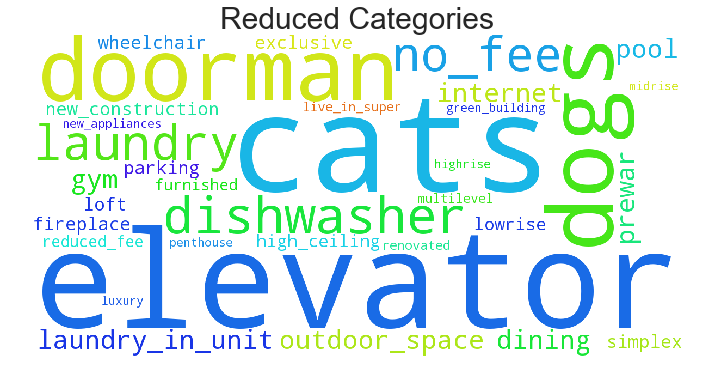

In [32]:
plt.figure(figsize=(12,6))
wc = WordCloud(background_color='white', width=1200, height=600).generate(text)
plt.title('Reduced Categories', fontsize=30)
plt.axis("off")
wc.recolor(random_state=0)
plt.imshow(wc);

In [64]:
# Create indicators
X_dummies = pd.get_dummies(df['categories'].apply(pd.Series).stack()).sum(level=0)

### Aggregate manager_id to get features representing manager performance
**Note:** Need to aggregate manager performance ONLY over a training subset in order to validate against test subset. Otherwise, for any given manager, a portion of their calculated skill level might have been due to listings from the test set. So the train-test split is being performed in this step before creating the columns for manager performance.

In [65]:
# Choose features for modeling (and sorting)
df = df.sort_values('listing_id')
X = df[['bathrooms','bedrooms','price','latitude','longitude','days_old','num_words','num_features','num_photos','listing_id','manager_id']]
y = df['interest_level']

In [66]:
# Merge indicators to X dataframe and sort again to match sorting of y
X = X.merge(X_dummies, how='outer', left_index=True, right_index=True).fillna(0)
X = X.sort_values('listing_id')

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [68]:
# compute ratios and count for each manager
mgr_perf = pd.concat([X_train.manager_id,pd.get_dummies(y_train)], axis=1).groupby('manager_id').mean()

In [69]:
mgr_perf.head(2)

,high,low,medium
manager_id,,,
0000abd7518b94c35a90d64b56fbf3e6,0.0,0.272727,0.727273
001ce808ce1720e24a9510e014c69707,0.0,1.000000,0.000000


In [70]:
# Apply weighting for each manager's listings: +1 for High, 0 for Medium, -1 for Low.
mgr_perf['manager_count'] = X_train.groupby('manager_id').count().iloc[:,1]
mgr_perf['manager_skill'] = mgr_perf['high']*1 + mgr_perf['medium']*0 + mgr_perf['low']*-1

In [71]:
# for training set
X_train = X_train.merge(mgr_perf.reset_index(), how='left', left_on='manager_id', right_on='manager_id')

In [72]:
# for test set
X_test = X_test.merge(mgr_perf.reset_index(), how='left', left_on='manager_id', right_on='manager_id')

# Fill na's with mean skill and median count
X_test['manager_skill'] = X_test.manager_skill.fillna(X_test.manager_skill.mean())
X_test['manager_count'] = X_test.manager_count.fillna(X_test.manager_count.median())

In [73]:
# Delete unnecessary columns before modeling
del X_train['listing_id']
del X_train['manager_id']
del X_test['listing_id']
del X_test['manager_id']
del X_train['high']
del X_train['medium']
del X_train['low']
del X_test['high']
del X_test['medium']
del X_test['low']

## Step 5: Modeling, second pass with Random Forest

In [78]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [114]:
y_test_predicted_proba = rf.predict_proba(X_test)
log_loss(y_test, y_test_predicted_proba)

0.59991955704408473

In [79]:
y_test_predicted = rf.predict(X_test)
accuracy_score(y_test, y_test_predicted)

0.73066947641432967

In [80]:
precision_recall_fscore_support(y_test, y_test_predicted)

(array([ 0.51055662,  0.8005352 ,  0.46216088]),
 array([ 0.27366255,  0.90747871,  0.34740608]),
 array([ 0.35632954,  0.85065894,  0.39665033]),
 array([ 972, 8571, 2795]))

In [117]:
rf.classes_

array([u'high', u'low', u'medium'], dtype=object)

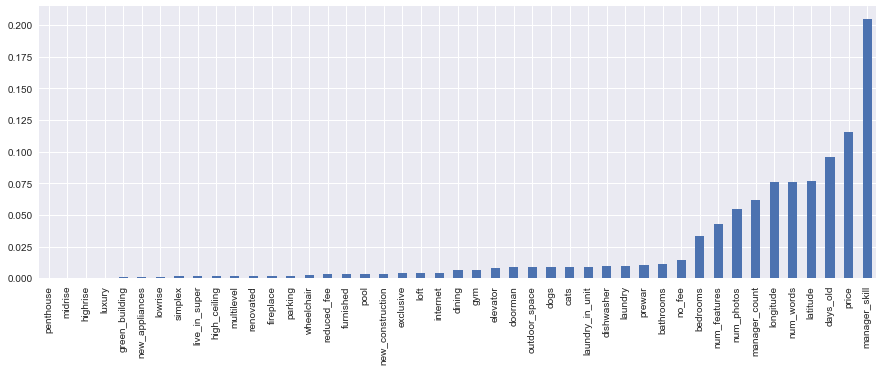

In [122]:
plt.figure(figsize=(15,5))
pd.Series(index = X_train.columns, data = rf.feature_importances_).sort_values().plot(kind = 'bar');

As seen here, introducing feature categories and manager performance has improved the model. In particular, `manager_skill` shows up as the dominant feature in terms of importance in this Random Forest model.

## Step 6: Image Classification Attempt
I did not use the actual listing images in my model. Here, I outline an attempt at classifying the listing based on image quality using a "blurry image" detector that I created with a Convolutional Neural Network. For more details see [my discussion of that project](http://tatineni.xyz/).

In [100]:
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense, Activation, Dropout
from keras.preprocessing import image

In [ ]:
# My neural network layer sequence is based on the original LeNet architecture
model = Sequential()

# Layer 1
model.add(Convolution2D(32, 5, 5, input_shape=(192, 192, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Convolution2D(64, 5, 5))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))    

model.add(Flatten())

# Layer 3
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Layer 4
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))

# Layer 5
model.add(Dense(2))
model.add(Activation("softmax"))

# "lenet_weights.h5" is the file containing weights from my trained neural network.
model.load_weights('lenet_weights.h5')

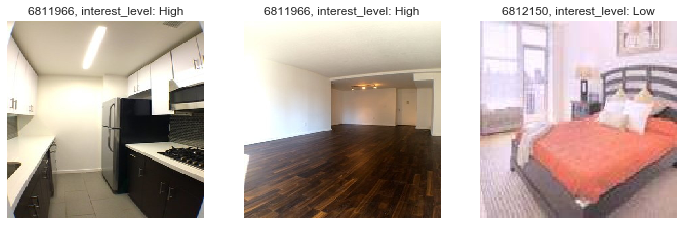

In [142]:
# Loading three images from the dataset.
# img_1 & img_2 are from the same High popularity listing
# img_3 is from a Low popularity listing.
pics = []

img_1 = image.load_img('6811966_1.jpg', target_size=(192,192))
pics.append(np.asarray(img_1))
img_2 = image.load_img('6811966_2.jpg', target_size=(192,192))
pics.append(np.asarray(img_2))
img_3 = image.load_img('6812150_1.jpg', target_size=(192,192))
pics.append(np.asarray(img_3))
pics_array = np.stack(pics)/255.
plt.figure(figsize=(12,12))
plt.subplot(131),plt.imshow(img_1),plt.title('6811966, interest_level: High')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_2),plt.title('6811966, interest_level: High')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_3),plt.title('6812150, interest_level: Low')
plt.xticks([]), plt.yticks([])
plt.show()

In [134]:
model.predict_classes(pics_array)

3/3 [==============================] - 0s


array([0, 1, 1])

My model classified the first image for listing 6811966 as 0 = clear, but the second as 1 = blurry. This is likely due to the larger prevalance of a white wash-out effect in the second image from sunlight.
The third image was classified correctly as 1 = blurry; it is indeed a blurry image. However, this alone is probably not enough to decide listing popularity.
As seen below, the typical listing has 5 photos attached, while the High popularity listing we are discussing here has a total of 7 photos. The Low popularity listing meanwhile has only this 1 photo. So the number of photos is just as likely as blurriness to affect listing popularity in this case.

In [151]:
df['num_photos'].mode()

0    5
dtype: int64

In [154]:
df['num_photos'].median()

5.0

In [143]:
df[df.listing_id == 6811966][['listing_id','description','interest_level','num_photos']]

,listing_id,description,interest_level,num_photos
114617,6811966,--- East 31st St & Lexington Avenue --- This S...,high,7


In [144]:
df[df.listing_id == 6812150][['listing_id','description','interest_level','num_photos']]

,listing_id,description,interest_level,num_photos
93083,6812150,Great bright and spacious 2 bedrooms two bathr...,low,1


## Step 7: Prediction and Further Opportunities
To make a prediction for submission to Kaggle, this notebook can be recreated with the `test.json` dataset. The submission requires the predicted high, medium, and low probabilities for each `listing_id`.  Kaggle rankings are based on the Log Loss value on the test set.
 
Further opportunities to improve prediction on this dataset may lie in NLP of the text descriptions, which were not used thus far except as a numerical "length" value. Building popularity could also be assessed via the `building_id` variable, similar to the aggregation of the `manager_id` variable.